In [1]:
import argparse
import json
import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from map_boxes import mean_average_precision_for_boxes
from itertools import product
from matplotlib import pyplot as plt
import cv2

from dataset import TestDataset
from model import load_net
from transform import get_test_transform
from func import collate_fn
from TTA import *

In [2]:
settings = {
    "annotation": "../../../stratified_kfold/cv_val_1.json",
    "data": "../../../detection/dataset",
    "batch_size": 4,
    "check_path": "./save/effiDet_d5_cutmix2/last-checkpoint.bin",
    "model_name": "tf_efficientdet_d5",
    "num_classes": 10,
    "image_size": [512, 512],
    "TTA": 1,
    "score_threshold": 0.0
}

In [3]:
annotation = settings['annotation']
data_dir = settings['data']
val_dataset = TestDataset(annotation, data_dir, get_test_transform())

checkpoint_path = settings["check_path"]

val_data_loader = DataLoader(
    val_dataset,
    batch_size=settings['batch_size'],
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = load_net(settings, checkpoint_path)
model.to(device)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
cuda


DetBenchPredict(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [ ]:
tta_transforms = []
    for tta_combination in product([TTAHorizontalFlip(), None], 
                                [TTAVerticalFlip(), None],
                                [TTARotate90(), TTARotate180(), TTARotate270(), None]):
        tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

[[  1  58 463 465]
 [  1 230 147 511]
 [288  17 487 265]
 [  1   0 121  42]
 [  1  95  57 304]
 [  1  25 124 107]
 [  1   0 121  42]
 [  1 143 119 404]
 [  1 229 139 511]
 [  1 152 139 503]]


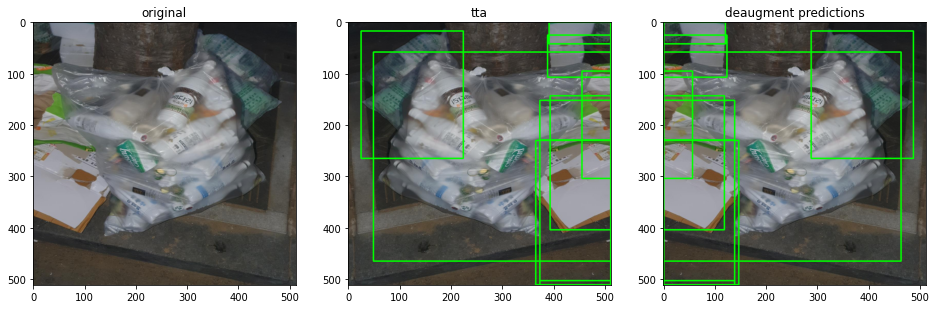

In [12]:
transform = TTACompose([
    # TTARotate270(),
    TTAVerticalFlip(),
])

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

image, image_id = val_dataset[1]

numpy_image = image.permute(1,2,0).cpu().numpy().copy()

ax[0].imshow(numpy_image);
ax[0].set_title('original')

tta_image = transform.augment(image)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()

det = model(tta_image.unsqueeze(0).float().cuda())

index = 0
boxes = det[index].detach().cpu().numpy()[:,:4]    
scores = det[index].detach().cpu().numpy()[:,4]
boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
boxes = (boxes).clip(min=0, max=511).astype(int)
score_threshold = 0.3
indexes = np.where(scores>score_threshold)
boxes = boxes[indexes]
scores = scores[indexes]

for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

ax[1].imshow(tta_image_numpy);
ax[1].set_title('tta')
    
boxes = transform.deaugment_boxes(boxes)
print(boxes)

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax[2].imshow(numpy_image);
ax[2].set_title('deaugment predictions');